Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/21


In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import re

from nltk.corpus import gutenberg
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

# LSA Drills





In [2]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))


In [3]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# splitting into training and test sets
X_train, X_test = train_test_split(emma_paras,test_size=0.4, random_state=0)

# Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
# List of features
terms = vectorizer.get_feature_names()
# for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1379
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'present': 0.71172190707814709, 'minutes': 0.70246133486836493}


In [4]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 48.0556985945
Component 0:
" Oh !     0.999245
" Oh !     0.999245
" Oh !"    0.999245
" Oh !     0.999245
" Oh !     0.999245
" Oh !"    0.999245
" Oh !     0.999245
" Oh !     0.999245
" Oh !     0.999245
" Oh !     0.999245
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.672849
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.612233
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.590364
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I thi

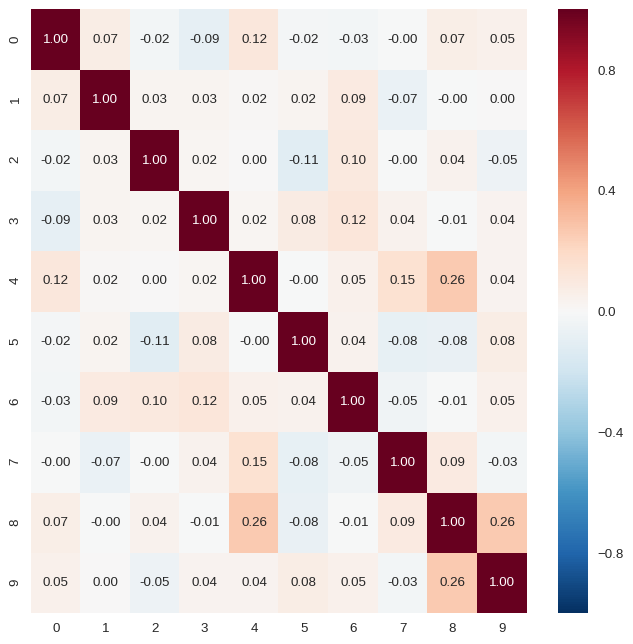

In [8]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = sb.heatmap(sim_matrix,yticklabels=range(10), annot=True, fmt=".2f")

## Drill 0
Appling Latent Semantic Analysis model to the test set.

In [12]:
# Applying the vectorizer
X_test_tfidf=vectorizer.fit_transform(X_test)
print("Number of features in test : %d" % X_test_tfidf.get_shape()[1])

# Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

# number of paragraphs
n = X_test_tfidf_csr.shape[0]
print("The number of paragraphs in test data : %d" % n)
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
# List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that 
# the word was present once in that sentence.
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features in test : 1029
The number of paragraphs in test data : 949
Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'elton': 0.17895867324012965, 'unexceptionable': 0.31859056127148594, 'assure': 0.2723505653720717, 'pass': 0.28591298493659739, 'resolving': 0.31859056127148594, 'watch': 0.6100562834139206, 'friends': 0.26679782816623454, 'replied': 0.2116362495750182, 'quite': 0.19766915990927683, 'really': 0.23967298903718312, 'mrs': 0.15619521683223178}


In [13]:
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 54.2416882139
Component 0:
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
" Oh !    0.999904
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.617100
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                                     

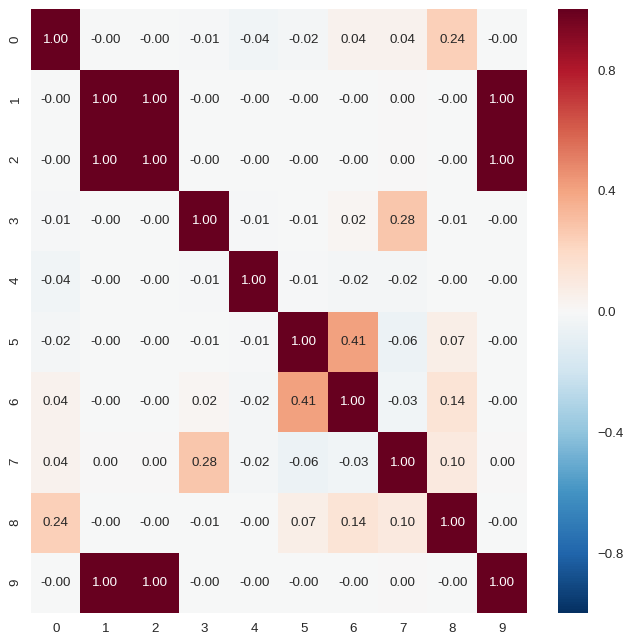

In [14]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
# Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity, index=X_test).iloc[0:10,0:10]
# Making a plot
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = sb.heatmap(sim_matrix,yticklabels=range(10), annot=True, fmt=".2f")

Performing latent semantic analysis on the test set identified similar components to that seen in the training set.  Specifically, components 0, 2 and 3.   The similarity matrix on the test data reveals a number of paragraphs pairs with perfect similarity. 

## Drill 1 : Tweaking tf-idf



In [31]:
nlp = spacy.load('en')
print('There are %d paragraphs\n' % len(emma_paras))

emma_doc = []

for para in emma_paras:
    emma_doc.append(nlp(para))

print('There are %d paragraphs\n' % len(emma_doc))

# normalize the paragraphs
normalized_emma = []

for para in emma_doc:
    l = [token.lemma_ for token in para if not token.is_punct and not token.is_stop and not token.is_digit]
    normalized_emma.append(' '.join(l))

print('There are %d normalized paragraphs\n' % len(normalized_emma))

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# splitting into training and test sets
X_train, X_test = train_test_split(normalized_emma,test_size=0.4, random_state=0)

# Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
print("The number of paragraphs in training data : %d" % n)

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that 
# the word was present once in that sentence.
print('Original normalized sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

There are 2371 paragraphs

There are 2371 paragraphs

There are 2371 normalized paragraphs

Number of features: 1200
The number of paragraphs in training data : 1422
Original normalized sentence: minute complete present trial
Tf_idf vector: {'minute': 0.53085943889255371, 'present': 0.54310197616628841, 'complete': 0.65056014297138987}


In [32]:
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 51.3403543998
Component 0:
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
oh    0.999083
Name: 0, dtype: float64
Component 1:
tall emma say mr knightley                                                                                                                                                                                                                                                                                                                                                                                                 0.631421
delicate subject emma say mrs weston smile remember mr                                                                                                                                                                                                                                                                           

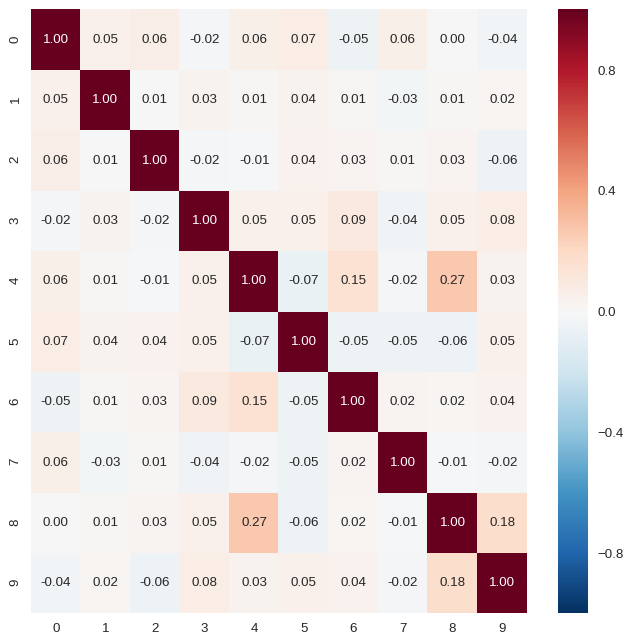

In [33]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = sb.heatmap(sim_matrix,yticklabels=range(10), annot=True, fmt=".2f")